This take-home assignment aims to build a model to predict the likelihood of default of credit card clients. I will discuss step-by-step processes in this notebook, from data exploration, pre-processing to model development and validation.

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
!pip install shap &> /dev/null
import shap

In [2]:
# Configure formats
RANDOM_SEED = 42
pd.set_option('max_columns', None, 'max_rows', None, 'display.float_format', lambda x: '%.2f' % x)
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=16)
plt.rc('lines', linewidth=2)
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('axes', axisbelow=True, grid=True, labelsize=16, titlesize=18)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray', labelsize=16)
plt.rc('ytick', direction='out', color='gray', labelsize=16)
plt.style.use('seaborn-white')
%config InlineBackend.figure_format='retina'

# **Data exploration**

Some observations about the data:

* The data consists of 300K rows and 25 features.
* Based on the summary statistics table, 22% of records label with default payment next month in this dataset. This default rate seems to be very high. Typically the default rate on credit cards is not more than 3-6%.
* From the boxplot, I see there are many outliers in many features.
* Seventy records have the same information except for the ID. Although these duplicates might be accurate real-world data that coincidentally have the same values, for now, I will remove these duplicates as they may bias the model.
* Several records with values lack definitions in the documentation. Based on the values (0 and -2) and the number of the rows with these values, I suspect they represent missing values. To deal with this issue, I will treat these values as unique values and let the model learn them during training.


In [3]:
# Load data from the website
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
df = pd.read_excel(url, skiprows=[0])

In [4]:
# Display the shape of the data frame
print('Number of records: %s\nFields in each record: %s' % (df.shape[0], df.shape[1]))

Number of records: 30000
Fields in each record: 25


In [5]:
# Preview the first two rows
df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [6]:
# Summary statistics
table = df.describe().loc[['min', 'max', 'mean', 'std']]
table.loc['null'] = df.isnull().sum()
table

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
min,1.00,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-165580.00,-69777.00,-157264.00,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,30000.00,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,8.00,8.00,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00,1.00
mean,15000.50,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,-0.27,-0.29,51223.33,49179.08,47013.15,43262.95,40311.40,38871.76,5663.58,5921.16,5225.68,4826.08,4799.39,5215.50,0.22
std,8660.40,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,1.13,1.15,73635.86,71173.77,69349.39,64332.86,60797.16,59554.11,16563.28,23040.87,17606.96,15666.16,15278.31,17777.47,0.42
null,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


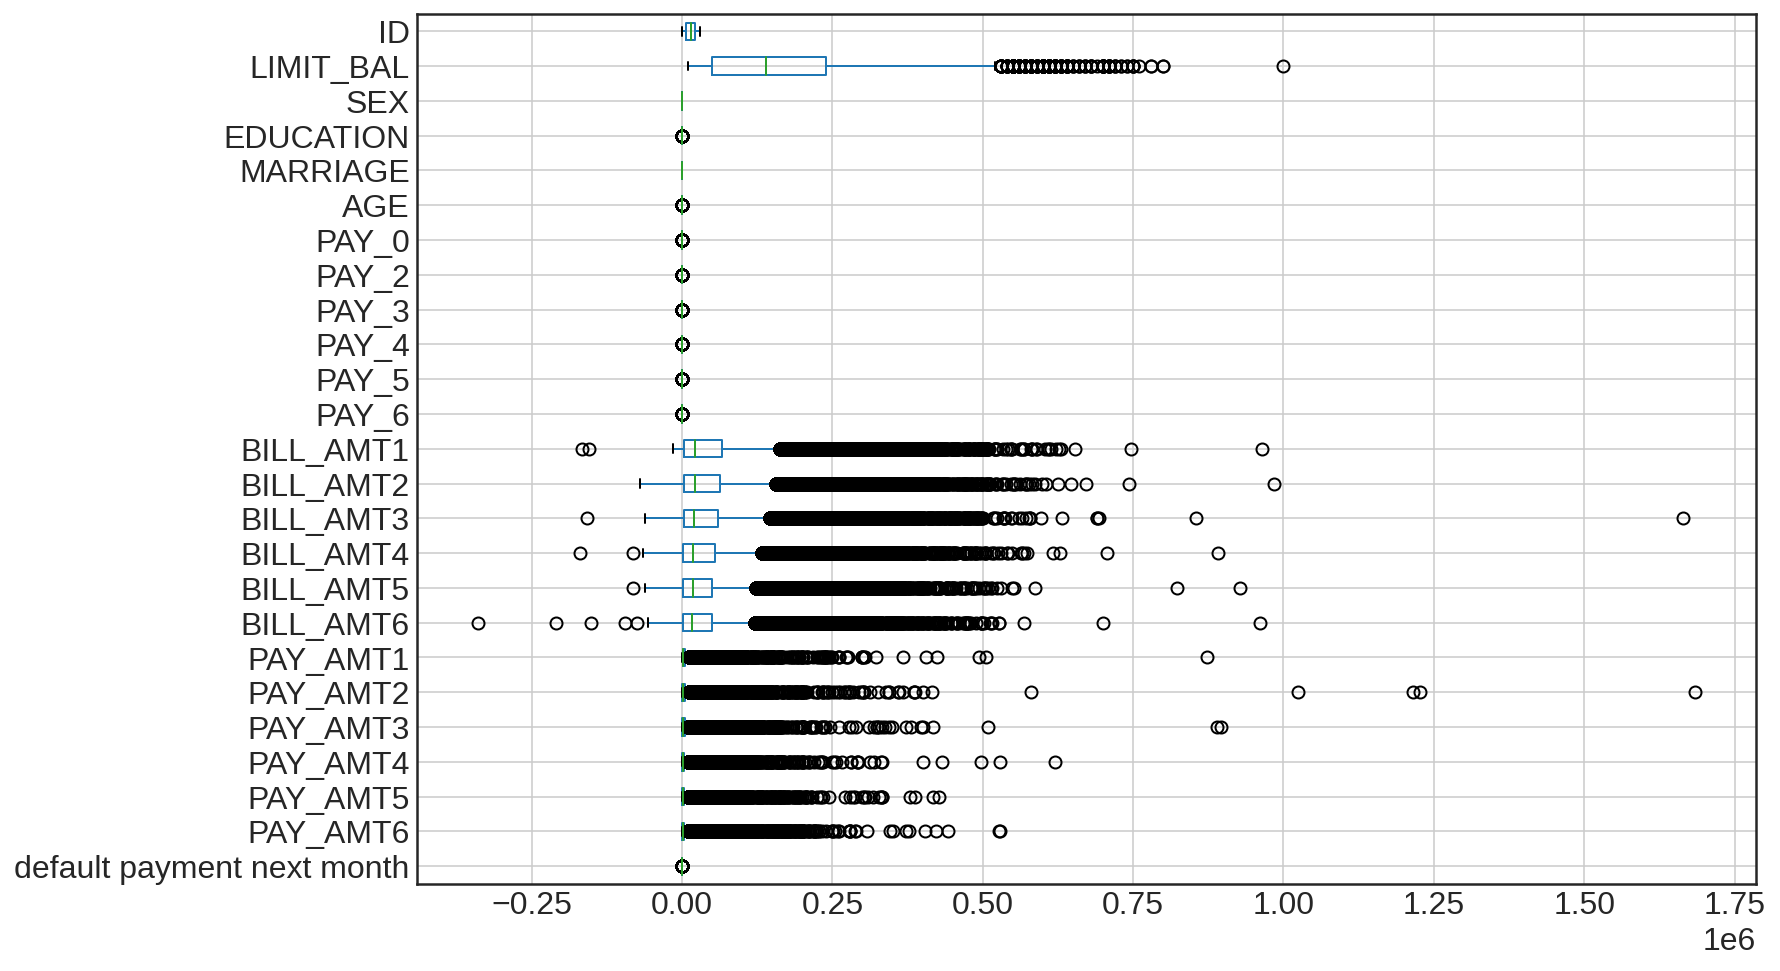

In [7]:
# Plot boxplot
cols = df.columns.to_list()[::-1]
df.boxplot(column=cols, vert=False, figsize=(12, 8))
plt.show()

In [8]:
# Duplicated records in the dataset
cols = df.columns[1:].to_list()
duplicated_records = df[df.duplicated(subset=cols, keep=False)].sort_values(cols).reset_index(drop=True)
print('%s records are duplicated' % duplicated_records.shape[0])
duplicated_records.head(2)

70 records are duplicated


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,12431,20000,1,2,2,24,2,2,4,4,4,4,1650,1650,1650,1650,1650,1650,0,0,0,0,0,0,1
1,14295,20000,1,2,2,24,2,2,4,4,4,4,1650,1650,1650,1650,1650,1650,0,0,0,0,0,0,1


In [9]:
# Records without values definitions in the documentation.
cols1 = ['SEX',	'EDUCATION', 'MARRIAGE', 'AGE']
cols2 = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df1 = pd.DataFrame((df[cols1]==0).sum(), columns=['Counts of rows without value definition'])
df2 = pd.DataFrame((df[cols2]<-1).sum(), columns=['Counts of rows without value definition'])
pd.concat([df1, df2])

,Counts of rows without value definition
SEX,0
EDUCATION,14
MARRIAGE,54
AGE,0
PAY_0,2759
PAY_2,3782
PAY_3,4085
PAY_4,4348
PAY_5,4546
PAY_6,4895


# **Data-processing**

A high-quality dataset is also the key to success. To prepare the data before modeling, I wrote a module to automate the process:
* Use 70% of the dataset for model development and 30% for tests.
* Remove features (e.g., sex, education level, marital status, and age) from the modeling to avoid credit discrimination.
* Create attributes based on the worst repayment status and minimum payment in the last six months.
* Downcast the data to reduce the memory footprint.
* Apply variance inflation factor (VIF) to remove highly correlated independent variables.


In [10]:
class data_preprocessing():

    '''
    Prepare data for model training.
    '''

    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.irrelevant_features = ['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

    def drop_duplicated_rows(self):
        # Drop duplicated records with the same information except for ID
        cols = [c for c in self.data.columns if c!='ID']
        self.data.drop_duplicates(subset=cols, inplace=True)

    def data_split(self):
        # Split the data into independent variables and the target variable
        y = self.data[self.target]
        X = self.data.drop(self.target, axis=1)
        return X, y

    def drop_irrelevant_features(self):
        # Remove features that the model will not use
        self.data.drop(self.irrelevant_features, axis=1, inplace=True, errors='ignore')
    
    def create_custom_features(self):
        # Create features based on the domain knowledge
        for m in range(1, 7):
            self.data['payment_ratio%s'%str(m)] = np.where(self.data['BILL_AMT%s'%str(m)]!=0, 
                                                         self.data['PAY_AMT%s'%str(m)].div(self.data['BILL_AMT%s'%str(m)]), 
                                                         0)
        self.data['worst_records_in_last_6months'] = self.data[['PAY_0', 'PAY_2', 'PAY_3', 
                                                                'PAY_4', 'PAY_5', 'PAY_6']].max(axis=1)
        self.data['min_payment_in_last_6months'] = self.data[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3',
                                                              'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].min(axis=1)
        
    def downcast(self):
        # Downcast the data to reduce data size
        self.data.apply(pd.to_numeric, downcast='float', errors='ignore')
    
    def calculate_vif(self, variables, thresh=5):
        # Calculate VIF to detect multicollinearity
        dropped = True if not variables else False
        var = self.data.columns.to_list() if not variables else variables
        while dropped:
            dropped = False
            vif = Parallel()(delayed(variance_inflation_factor)(self.data[var].values, ix) for ix in range(len(var)))
            maxloc = vif.index(max(vif))
            if max(vif) > thresh:
                var.pop(maxloc)
                dropped = True
        self.data = self.data[var]

    def steps(self, variables=[]):
        # Data cleaning steps
        self.drop_duplicated_rows()
        self.data, self.y = self.data_split()
        self.drop_irrelevant_features() 
        self.create_custom_features()
        self.downcast()
        self.calculate_vif(variables)
        self.data.reset_index(drop=True, inplace=True)

        return self.data, self.y
    

In [11]:
# Prepare dataset
# Hold out 30% of data as a validation dataset and use a module to automate the data processing process
target = 'default payment next month'
train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
X_train, y_train = data_preprocessing(train, target).steps()
X_test, y_test = data_preprocessing(test, target).steps(variables=X_train.columns.to_list())

In [12]:
# Preview cleaned dataset
X_train.head(2)

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,payment_ratio1,payment_ratio2,payment_ratio3,payment_ratio4,payment_ratio5,payment_ratio6,worst_records_in_last_6months,min_payment_in_last_6months
0,240000,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,-2,0
1,50000,-1,-1,-1,-1,-1,-1,3430,2548,2321,4800,9810,660,2980,0.74,0.94,2.09,2.04,0.07,4.52,-1,660


# **Model building**

There are several essential aspects when modeling credit default:

* A classifier is only as good as the metric used to evaluate it. Choosing an appropriate metric is challenging but is particularly important for imbalanced datasets. Generally speaking, the default rate is not high. Commonly used metrics such as accuracy works well with roughly equal classes distribution. However, it does not show prediction capacity for the minority class in the imbalanced class situation. Here I choose to use metrics that are not biased towards majority classes, such as AUC and confusion matrix.

* Several simpling methods are available to handle the imbalanced problem. An example of such an up-sampling method is SMOTENC (Synthetic Minority Over-Sampling Technique for Nominal and Continuous). But, synthetic data may not satisfy legal requirements for compliance. SMOTE is also computationally expensive. For now, I will focus on other approaches to improve my modeling.

* Supervised tree-based techniques such as XGboost tend to perform well when there are outliers, unique values, and sufficiently large data. Using the feature importance, we can also examine the impact of variables on model prediction in a principled way.

* When we apply for a credit card but get declined, the bank will tell us why they decided. We may hear things like our previous credit card balance is too low etc. This bank requirement means that the model has a monotonical relationship between credit card balance and risk. Therefore, I use model monotonicity during the modeling as it is essential to ensure fairness of the model prediction. 

* To optimize the model for the task, I fine-tune hyperparameters using grid search. I focus on turning on the decision tree's learning rate, depth, and size as these parameters typically have the highest impact on the model outcome.

In [13]:
# Estimate classes weight for scale_pos_weight value
counter = Counter(y_train)
class_weights = round(counter[0]/counter[1]) 

# Montonic constraints
monotonic_table = {'LIMIT_BAL':0, 'PAY_0':1, 'PAY_2':1, 'PAY_3':1, 'PAY_4':1, 'PAY_5':1, 'PAY_6':1,'BILL_AMT1':1, 
                   'PAY_AMT1':-1, 'PAY_AMT2':-1, 'PAY_AMT3':-1, 'PAY_AMT4':-1, 'PAY_AMT5':-1,'PAY_AMT6':-1, 
                   'payment_ratio1':-1, 'payment_ratio2':-1, 'payment_ratio3':-1, 'payment_ratio4':-1, 
                   'payment_ratio5':-1, 'payment_ratio6':-1, 'worest_records_in_last_6months':1,
                   'min_payment_in_last_6months':1}
feature_monotones = '(' + ','.join([str(m) for m in monotonic_table.values()]) + ')'

# Model parameters 
tune = False
if tune:
    parameters = {
                'max_depth': [6, 8, 10],
                'learning_rate': [0.005, 0.01, 0.02],
                'n_estimators': [300, 500, 800]
                }
    model = XGBClassifier(scale_pos_weight=class_weights, 
                          monotone_constraints=feature_monotones, 
                          tree_method='hist', 
                          random_state=RANDOM_SEED)
    clf = GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, cv=5)
    clf.fit(X_train, y_train)
    xgboost_clf = clf.best_estimator_
else:
    xgboost_clf = XGBClassifier(max_depth=8, 
                                n_estimators=500, 
                                learning_rate=0.01, 
                                scale_pos_weight=class_weights, 
                                monotone_constraints=feature_monotones, 
                                tree_method='hist', 
                                random_state=RANDOM_SEED)
    xgboost_clf.fit(X_train, y_train)

# **Result and summary**

1. The model predicts credit default well in the test set. Generally speaking, 0.7 to 0.8 of AUC is considered good. At here, we have AUC 0.77. The score matrix, which visualizes classification results, shows that the model makes predictions about 70% on true positive and true negative rates. The model predicts well on both classes, despite the relatively small default records in the dataset.

2. SHAP beeswarm plot displays how the top features impact the model's predictions. The worst repayment status in the last six months is the most predictive feature - the more payment delay during the past six months, the more likely the default is. The following important variable is also related to the repayment status but is in the previous month. The third important variable is credit limit. The higher the limit, the lower probability to be default next month. This result suggests a person who has a high credit limit has a better financial habit and is unlikely to miss a payment. The evaluation of model feature importance verifies that what the model is doing is in line with what we expect.

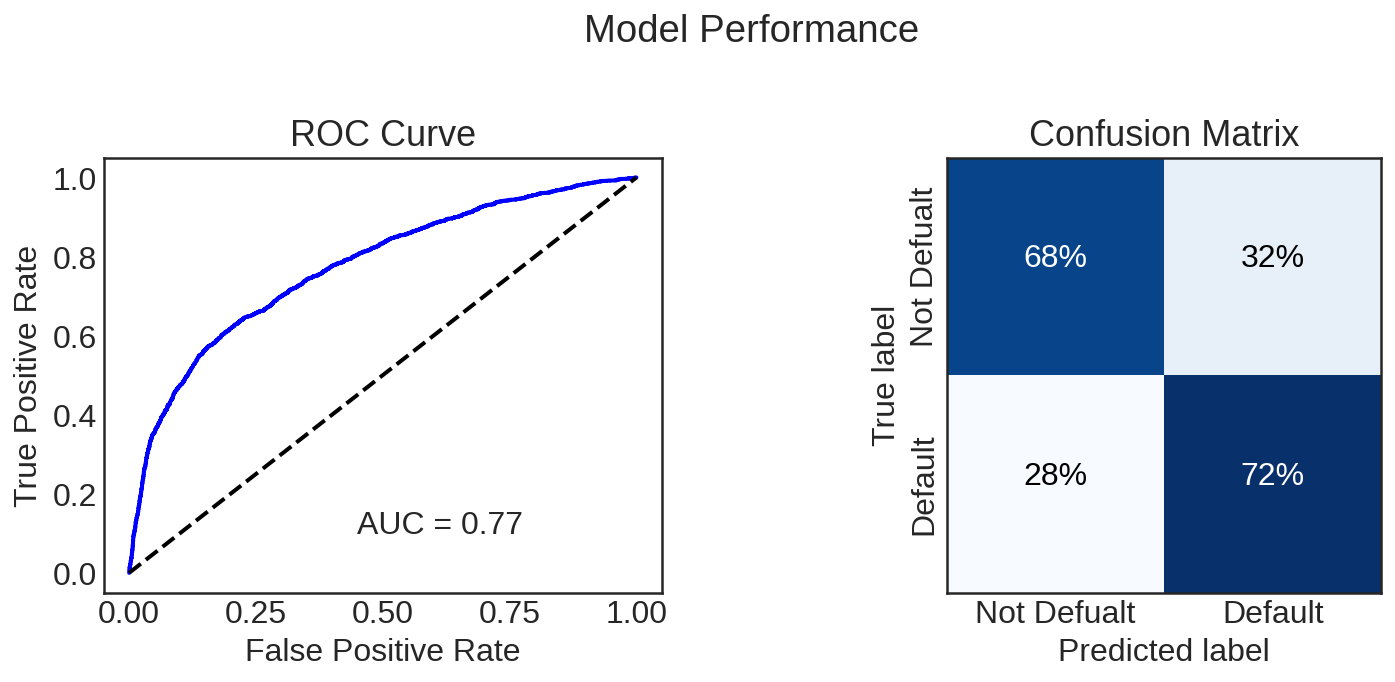

In [14]:
def model_evaluation(X_test, y_test, threshold=0.4):

    y_score = xgboost_clf.predict_proba(X_test)[:,1]
    y_pred = np.array([1 if (p>=threshold) else 0 for p in y_score])
    
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle('Model Performance')
    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.5)

    # ROC curve
    test_fpr, test_tpr, _ = roc_curve(y_test, y_score)
    ax1 = plt.subplot(grid[0, 0])
    ax1.plot(test_fpr, test_tpr, color="blue", lw=2)
    ax1.plot([0, 1], [0, 1], "k--")
    ax1.text(0.45, 0.1, "AUC = %0.2f" % roc_auc_score(y_test, y_score))
    ax1.set_title("ROC Curve")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    
    # Confusion metrix and recall
    cm = confusion_matrix(y_test, y_pred, normalize='true')*100
    ax2 = plt.subplot(grid[0, 1])
    ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix')
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    classNames = ['Not Defualt','Default']
    tick_marks = np.arange(len(classNames))
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(classNames)
    ax2.set_yticklabels(classNames, rotation=90, verticalalignment='center')
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax2.text(j, i, format(str(round(cm[i, j]))+'%', 's'),
                 horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else 'black')    
    plt.show()
model_evaluation(X_test, y_test)

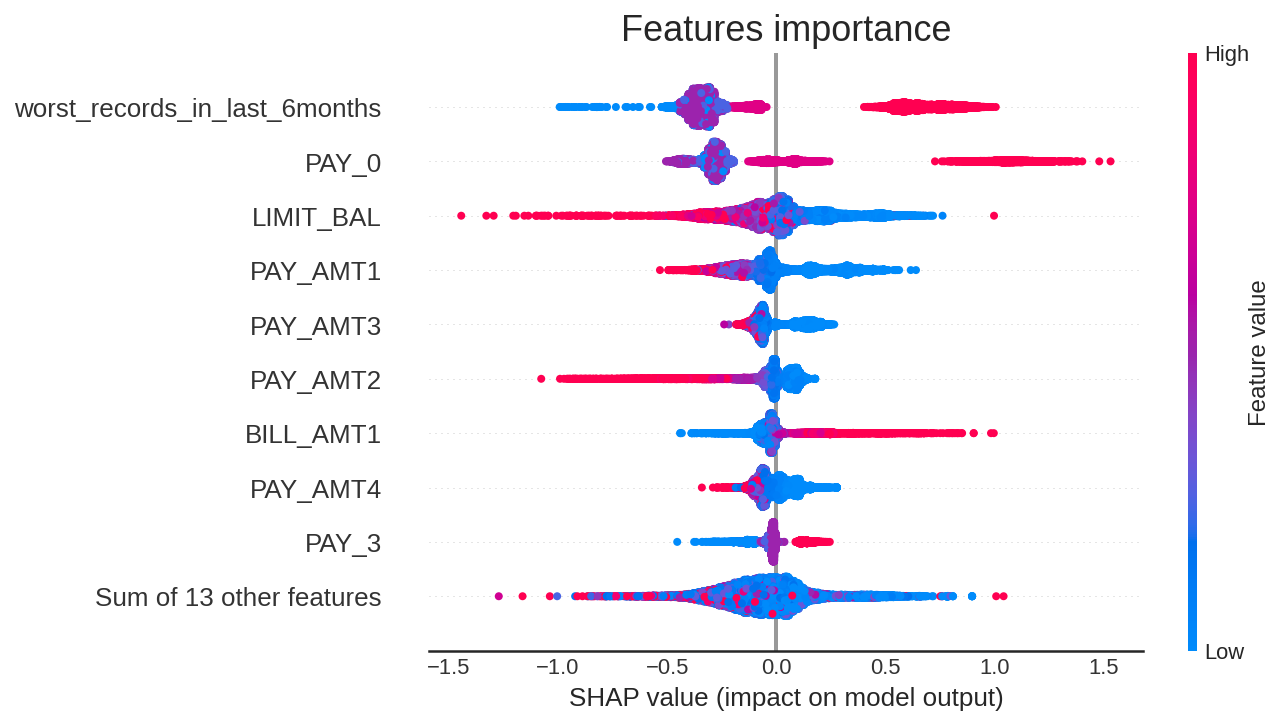

In [15]:
# Feaure importances
explainer = shap.Explainer(xgboost_clf)
shap_values = explainer(X_train)
plt.title('Features importance')
shap.plots.beeswarm(shap_values, max_display=10)